In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv


In [1]:
import pandas as pd
import numpy as np
import scipy
from bs4 import BeautifulSoup
import re
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
!spacy download en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
import matplotlib.pyplot as plt

In [3]:
train_df = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv')
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


DATA CLEANING

In [4]:
train_df.duplicated().sum()

0

In [5]:
# A list of the columns in the training dataframe
train_columns = train_df.columns

In [6]:
for i in train_columns:
  print(i,' contains: %f missing values' %train_df[i].isna().sum())

id  contains: 0.000000 missing values
comment_text  contains: 0.000000 missing values
toxic  contains: 0.000000 missing values
severe_toxic  contains: 0.000000 missing values
obscene  contains: 0.000000 missing values
threat  contains: 0.000000 missing values
insult  contains: 0.000000 missing values
identity_hate  contains: 0.000000 missing values


In [7]:
columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_train = pd.DataFrame(columns = columns)

for i in columns:
  y_train[i] = train_df[i]

train_df = train_df.drop(['id','toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], axis=1)
y_train.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [8]:
train_df.head()

,comment_text
0,Explanation\nWhy the edits made under my usern...
1,D'aww! He matches this background colour I'm s...
2,"Hey man, I'm really not trying to edit war. It..."
3,"""\nMore\nI can't make any real suggestions on ..."
4,"You, sir, are my hero. Any chance you remember..."


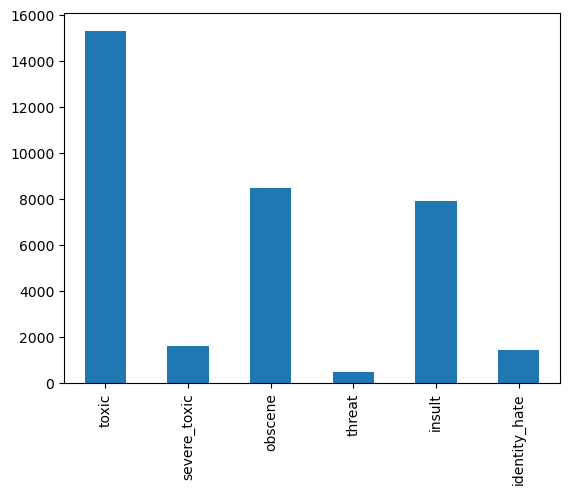

In [9]:
y_train.sum(axis = 0).plot.bar()
plt.show()

In [10]:
test_df = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv')
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [11]:
y_test = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv')
y_test = y_test.drop('id', axis=1)
y_test.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,-1,-1,-1,-1,-1,-1
1,-1,-1,-1,-1,-1,-1
2,-1,-1,-1,-1,-1,-1
3,-1,-1,-1,-1,-1,-1
4,-1,-1,-1,-1,-1,-1


In [12]:
y_test = y_test.replace(-1, 0)
y_test.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


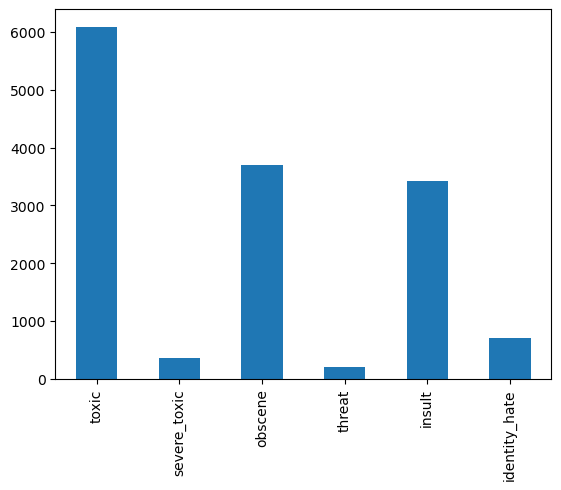

In [13]:
y_test.sum(axis = 0).plot.bar()
plt.show()

In [14]:
def clean_data(text):
  # Remove hyperlinks
  res = re.sub('https\S+|www\S+|https\S+', '', text)

  # Remove special character
  res = re.sub('[^\w\s]', '', res)

  # Remove numbers
  res = re.sub('\d+', '', res)

  return res

In [15]:
train_df = train_df['comment_text'].apply(clean_data)
print(train_df.head())

test_df = test_df['comment_text'].apply(clean_data)
print(test_df.head())

0    Yo bitch Ja Rule is more succesful then youll ...
1        From RfC  \n\n The title is fine as it is IMO
2     \n\n  Sources  \n\n  Zawe Ashton on Lapland     
3    If you have a look back at the source the info...
4              I dont anonymously edit articles at all
Name: comment_text, dtype: object

In [25]:
vectorizer = layers.TextVectorization(max_tokens = 6000, output_mode="tf-idf", ngrams=1)


with tf.device('CPU'):
  vectorizer.adapt(train_df)

In [26]:
train_df = vectorizer(train_df)
test_df = vectorizer(test_df)

print("train_df:", train_df.shape)
print("test_df:", test_df.shape)

train_df: (159571, 6000)
test_df: (153164, 6000)


In [27]:
test_df[:10]

<tf.Tensor: shape=(10, 6000), dtype=float32, numpy=
array([[82.613434  ,  0.        ,  0.98910034, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.91389847,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [19.064638  ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [63.548794  ,  3.6555939 ,  2.967301  , ...,  0.        ,
         0.        ,  0.        ],
       [12.709759  ,  1.8277969 ,  2.967301  , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)>

Build the Model

In [28]:
model = keras.Sequential([
    layers.Dense(100, input_shape=(6000,), activation = "relu"),

    layers.Dense(50, activation = "relu"),

    layers.Dense(6, activation = "sigmoid")
])
model.compile(
optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["binary_accuracy"]
)

In [29]:
nn = model.fit(train_df, y_train, epochs= 50, validation_data = (test_df, y_test))

Epoch 1/50
4987/4987 [==============================] - 36s 7ms/step - loss: 0.0886 - binary_accuracy: 0.9781 - val_loss: 0.2108 - val_binary_accuracy: 0.9473
Epoch 2/50
4987/4987 [==============================] - 35s 7ms/step - loss: 0.0521 - binary_accuracy: 0.9834 - val_loss: 0.2522 - val_binary_accuracy: 0.9351
Epoch 3/50
4987/4987 [==============================] - 33s 7ms/step - loss: 0.0397 - binary_accuracy: 0.9866 - val_loss: 0.2792 - val_binary_accuracy: 0.9353
Epoch 4/50
4987/4987 [==============================] - 33s 7ms/step - loss: 0.0298 - binary_accuracy: 0.9894 - val_loss: 0.2809 - val_binary_accuracy: 0.9362
Epoch 5/50
4987/4987 [==============================] - 33s 7ms/step - loss: 0.0237 - binary_accuracy: 0.9919 - val_loss: 0.4074 - val_binary_accuracy: 0.9279
Epoch 6/50
4987/4987 [==============================] - 33s 7ms/step - loss: 0.0218 - binary_accuracy: 0.9932 - val_loss: 0.3748 - val_binary_accuracy: 0.9314
Epoch 7/50
4987/4987 [========================

In [31]:
import pickle

In [46]:
# Save the model

filename = 'finalized_model.pkl'
pickle.dump(model, open(filename, 'wb'))